# Azure LLM inference traces
The trace description can be found [here](https://github.com/Azure/AzurePublicDataset/blob/master/AzureLLMInferenceDataset2023.md).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TRACE_NAMES = [
    "Coding",
    "Conversation",
]
TRACE_FILENAMES = [
    "AzureLLMInferenceTrace_code.csv",
    "AzureLLMInferenceTrace_conv.csv",
]
# Read all traces
df_traces = {}
for trace_name, trace_filename in zip(TRACE_NAMES, TRACE_FILENAMES):
    df_traces[trace_name] = pd.read_csv(trace_filename, parse_dates=["TIMESTAMP"])
convo_trace = df_traces["Conversation"]
first_timestamp = convo_trace['TIMESTAMP'].iloc[0]
convo_trace['TIMESTAMP'] = convo_trace['TIMESTAMP'] - first_timestamp
convo_trace['TIMESTAMP'] = convo_trace['TIMESTAMP'].dt.total_seconds()
convo_trace.drop("ContextTokens", axis=1, inplace=True)
convo_trace.drop("GeneratedTokens", axis=1, inplace=True)
convo_trace = convo_trace[convo_trace['TIMESTAMP'] != 0.0]
first_timestamp = convo_trace['TIMESTAMP'].iloc[0]
convo_trace['TIMESTAMP'] = convo_trace['TIMESTAMP'] - first_timestamp
send_out_times = list(convo_trace["TIMESTAMP"])

/tmp/ipykernel_304749/3525499646.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  convo_trace['TIMESTAMP'] = convo_trace['TIMESTAMP'] - first_timestamp


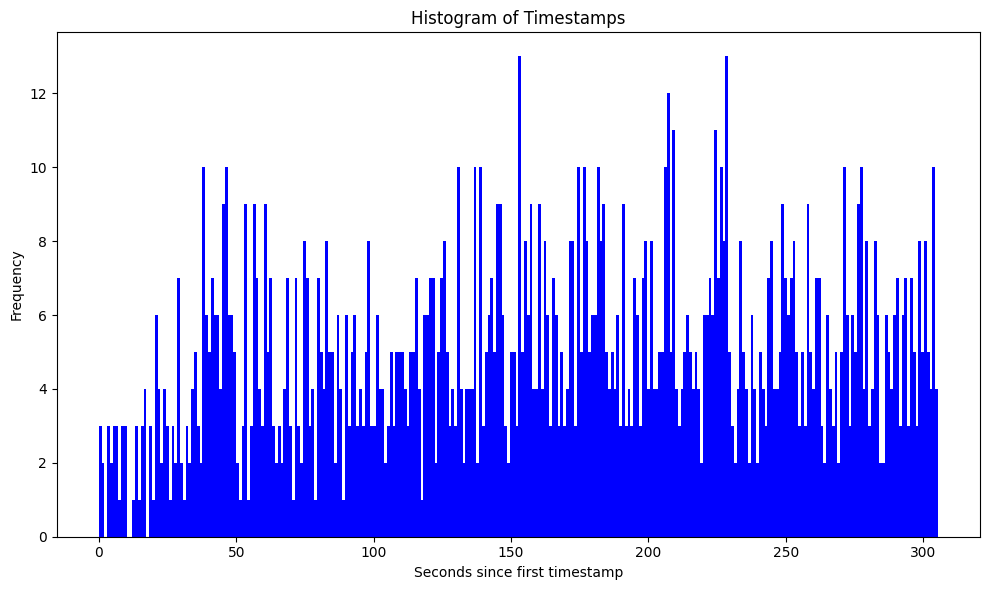

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(send_out_times[:1500], bins=300, color='blue')

plt.title('Histogram of Timestamps')
plt.xlabel('Seconds since first timestamp')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [5]:
len()

19365

In [7]:
max()

305.44813300000004

In [9]:
send_out_times[1800:]

[375.47121400000003,
 375.670921,
 375.71796,
 375.933156,
 376.24798400000003,
 376.24888000000004,
 376.345634,
 376.611313,
 376.823285,
 377.23323500000004,
 377.277683,
 377.29024300000003,
 377.48798800000003,
 377.648236,
 378.32578800000005,
 378.477411,
 378.47961200000003,
 378.52603400000004,
 378.5702,
 379.377339,
 379.414492,
 379.495558,
 379.733019,
 380.041668,
 380.63678600000003,
 381.16749400000003,
 381.210931,
 381.714622,
 382.380421,
 382.41213700000003,
 382.52599200000003,
 382.68581900000004,
 382.76063600000003,
 383.15999100000005,
 383.544689,
 383.677434,
 383.725139,
 383.782553,
 383.81875,
 384.195305,
 384.34367000000003,
 384.64272700000004,
 384.69032300000003,
 384.762621,
 384.920729,
 385.179837,
 385.280353,
 385.625807,
 385.721558,
 385.79879,
 385.980177,
 386.253755,
 386.4198,
 386.74394,
 386.777336,
 386.874568,
 387.092487,
 387.69258,
 387.725502,
 387.823513,
 388.362183,
 388.450017,
 388.50259500000004,
 388.502952,
 389.214804,
 389

In [48]:
convo_trace

,TIMESTAMP
0,0.000000
1,4.314579
2,4.541877
3,4.710427
4,5.892655
...,...
19361,3497.463643
19362,3497.879914
19363,3498.030189
19364,3501.060254


Coding


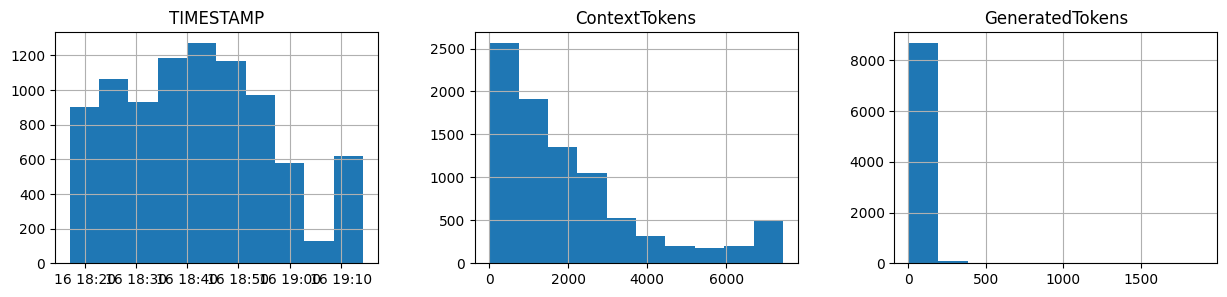

Conversation


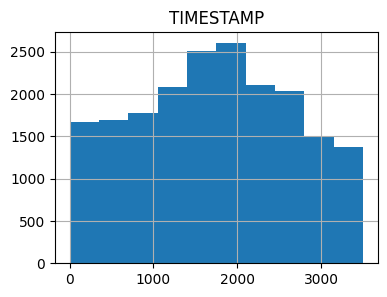

In [46]:
for trace_name, df_trace in df_traces.items():
    print(trace_name)
    df_trace.hist(
        layout=(1, 3),
        figsize=(15, 3),
    )
    plt.show()

## Token distributions

In [11]:
def get_cdf(df, field):
    vals = sorted(df[field].values)
    invs = 100.0 * np.arange(0, len(df)) / len(df)
    return vals, invs

In [12]:
def plt_tokens(dfs, field="ContextTokens", title="Input Tokens"):
    for df_key, df in dfs.items():
        df_tokens, df_inv = get_cdf(df, field)
        plt.plot(df_tokens, df_inv, label=df_key)
    plt.title(title)
    plt.ylabel("CDF")
    plt.xlabel("Number of tokens")
    plt.legend()
    plt.grid()
    plt.show()

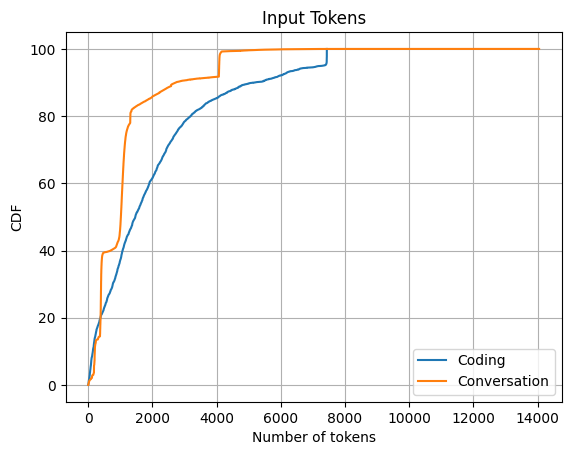

In [13]:
plt_tokens(df_traces, "ContextTokens", "Input Tokens")

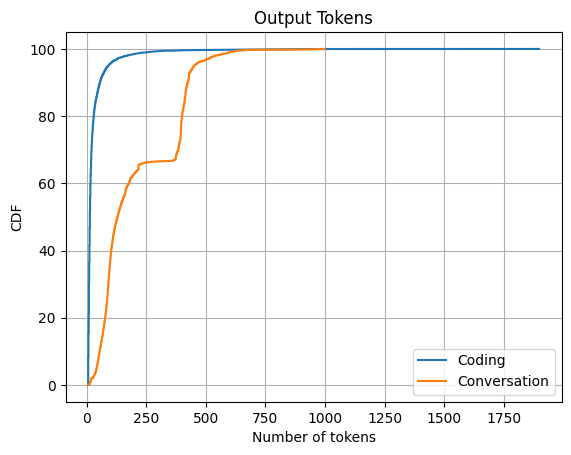

In [14]:
plt_tokens(df_traces, "GeneratedTokens", "Output Tokens")

## Correlation

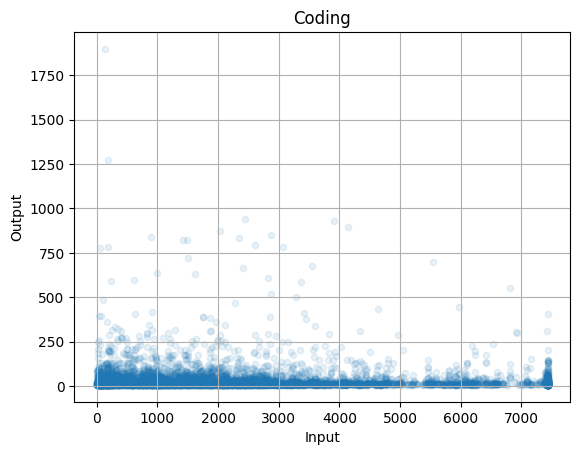

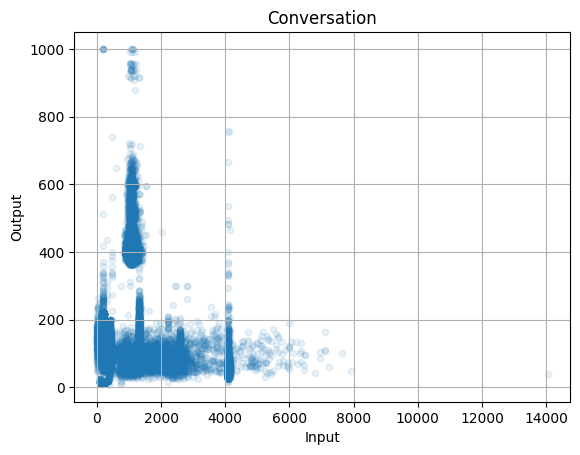

In [15]:
for trace_name, df_trace in df_traces.items():
    df_trace[["ContextTokens", "GeneratedTokens"]].plot.scatter(
        x="ContextTokens",
        y="GeneratedTokens",
        xlabel="Input",
        ylabel="Output",
        alpha=0.1,
        grid=True,
        title=trace_name,
    )
    plt.show()

## Analysis over time

In [16]:
def plt_invocations_time(df):
    df_copy = df.copy()
    df_copy["Time"] = df_copy["TIMESTAMP"].dt.round(freq="min")
    df_copy.groupby("Time").count()["TIMESTAMP"].plot(
        grid=True,
        ylim=0,
    )
    plt.ylabel("Number of invocations per minute")
    plt.show()

In [18]:
def plt_tokens_time(df, field="ContextTokens", label="Input", show=False):
    df_copy = df.copy()
    df_copy["Time"] = df_copy["TIMESTAMP"].dt.round(freq="min")
    df_copy.groupby("Time").sum()[field].plot(
        grid=True,
        ylim=0,
        label=label,
    )
    plt.ylabel("Number of tokens per minute")
    plt.legend()
    if show:
        plt.show()

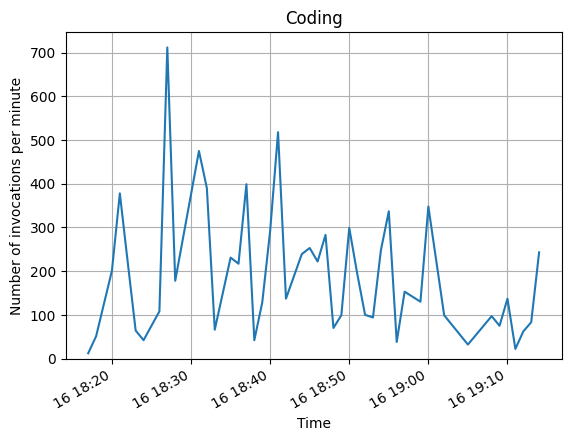

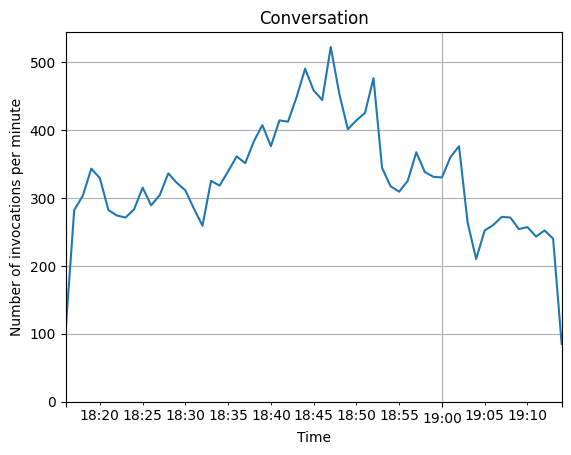

In [19]:
for trace_name, df_trace in df_traces.items():
    plt.title(trace_name)
    plt_invocations_time(df_trace)

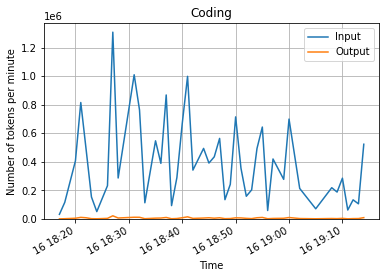

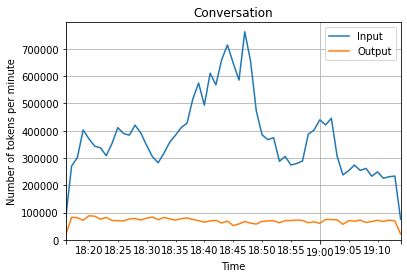

In [16]:
for trace_name, df_trace in df_traces.items():
    plt.title(trace_name)
    plt_tokens_time(df_trace, "ContextTokens", "Input")
    plt_tokens_time(df_trace, "GeneratedTokens", "Output")
    plt.show()